# Task 1: Data Analysis and Preprocessing

This notebook covers data loading, cleaning, feature engineering, merging IP-country, and preparing for modeling.

---

## 1. Imports and Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

import datetime
import warnings
warnings.filterwarnings("ignore")


---

## 2. Load Data


In [2]:
fraud_data = pd.read_csv('data/Fraud_Data.csv')
ip_data = pd.read_csv('data/IpAddress_to_Country.csv')
credit_data = pd.read_csv('data/creditcard.csv')


---

## 3. Initial Cleaning
- Remove duplicates
- Check & fix dtypes
- Check missing values


In [3]:
# Remove duplicates
fraud_data.drop_duplicates(inplace=True)
credit_data.drop_duplicates(inplace=True)

# Convert time columns
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

# Check missing
print(fraud_data.isnull().sum())
print(credit_data.isnull().sum())


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


---

## 4. Feature Engineering
### a. Time-based Features (Fraud Data)



In [4]:
fraud_data['time_since_signup'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds()
fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek


### b. Transaction Frequency Feature


In [5]:
tx_freq = fraud_data.groupby('user_id')['purchase_time'].count().rename('user_transaction_count')
fraud_data = fraud_data.merge(tx_freq, on='user_id')


---

## 5. IP Geolocation Merge
Convert IP to int, merge with range mapping.


In [6]:
fraud_data['ip_int'] = fraud_data['ip_address'].astype(int)

In [7]:
# --- Data Cleaning and Preprocessing ---

# 1. Remove duplicates
fraud_data.drop_duplicates(inplace=True)

# 2. Convert time columns to datetime
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

# 3. Handle missing values (if any)
# (You already have no missing IPs, but this is good practice)
fraud_data = fraud_data[fraud_data['ip_address'].notnull()]

# 4. Convert ip_address to integer (accommodating float input)
fraud_data['ip_int'] = fraud_data['ip_address'].astype(float).astype(int)

# 5. Prepare ip_data for merging
ip_data['lower'] = ip_data['lower_bound_ip_address'].astype(int)
ip_data['upper'] = ip_data['upper_bound_ip_address'].astype(int)

# 6. Map each ip_int to a country
def map_ip_to_country(ip):
    match = ip_data[(ip_data['lower'] <= ip) & (ip_data['upper'] >= ip)]
    return match['country'].values[0] if not match.empty else 'Unknown'

fraud_data['country'] = fraud_data['ip_int'].apply(map_ip_to_country)

# 7. Feature engineering
fraud_data['time_since_signup'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds()
fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek
tx_freq = fraud_data.groupby('user_id')['purchase_time'].count().rename('user_transaction_count')
fraud_data = fraud_data.merge(tx_freq, on='user_id')

# 8. One-hot encoding (including the new 'country' column)
fraud_data = pd.get_dummies(fraud_data, columns=['source', 'browser', 'sex', 'country'], drop_first=True)

# 9. Scaling numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
fraud_data['purchase_value'] = scaler.fit_transform(fraud_data[['purchase_value']])
fraud_data['time_since_signup'] = scaler.fit_transform(fraud_data[['time_since_signup']])

# 10. Train-test split and SMOTE (class imbalance handling)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
X = fraud_data.drop(columns=['class', 'signup_time', 'purchase_time', 'ip_address', 'device_id', 'user_id', 'ip_int'])
y = fraud_data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

---

## 6. Encode Categorical Features


In [8]:
cols_to_encode = [col for col in ['source', 'browser', 'sex', 'country'] if col in fraud_data.columns]
if cols_to_encode:
    fraud_data = pd.get_dummies(fraud_data, columns=cols_to_encode, drop_first=True)
else:
    print("No categorical columns to encode.")

No categorical columns to encode.


---

## 7. Scale Numerical Features


In [9]:
scaler = StandardScaler()
fraud_data['purchase_value'] = scaler.fit_transform(fraud_data[['purchase_value']])
fraud_data['time_since_signup'] = scaler.fit_transform(fraud_data[['time_since_signup']])


---

## 8. Handle Class Imbalance (Fraud_Data)
Using SMOTE on the training set.


In [10]:
X = fraud_data.drop(columns=['class', 'signup_time', 'purchase_time', 'ip_address', 'device_id', 'user_id', 'ip_int'])
y = fraud_data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE only to train set
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Optional: check distribution
print(y_train.value_counts())
print(y_train_bal.value_counts())


class
0    109568
1     11321
Name: count, dtype: int64
class
0    109568
1    109568
Name: count, dtype: int64


---

## 9. EDA Plots (Univariate Examples)


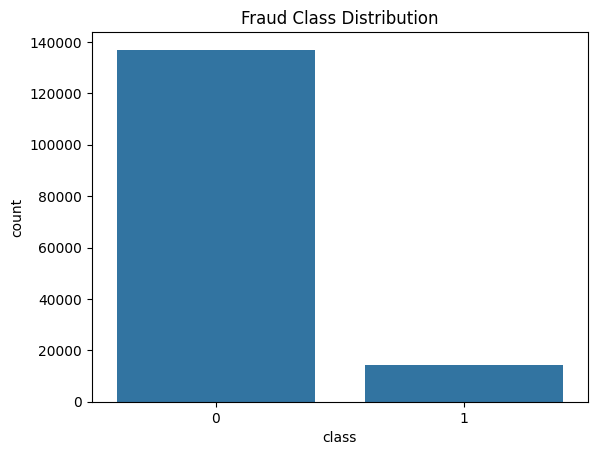

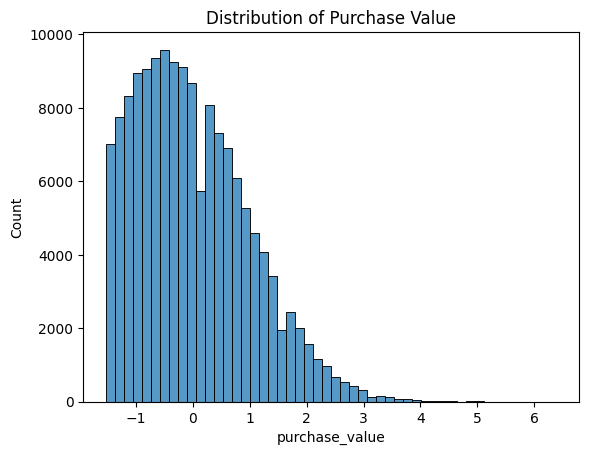

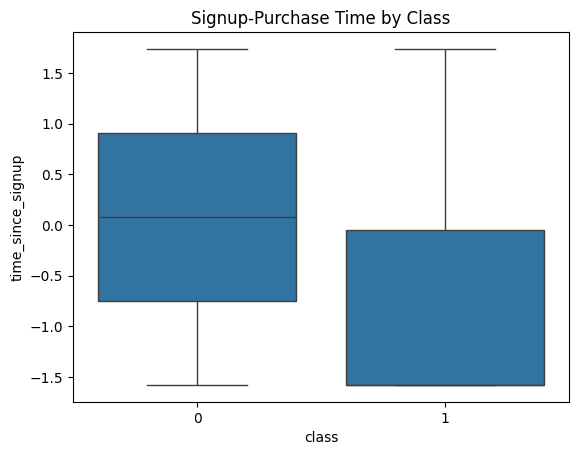

In [11]:
sns.countplot(x='class', data=fraud_data)
plt.title("Fraud Class Distribution")
plt.show()

sns.histplot(fraud_data['purchase_value'], bins=50)
plt.title("Distribution of Purchase Value")
plt.show()

sns.boxplot(x='class', y='time_since_signup', data=fraud_data)
plt.title("Signup-Purchase Time by Class")
plt.show()
